# Image Classification (MNIST)

### Imports

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torch.utils.data import DataLoader

import random
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

cpu


### 1. MNIST dataset

In [ ]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



In [ ]:
# dataset loader
batch_size = 100
data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

### 2. CNN model

- Input(입력의 형태)
  + Input type: torch.Tensor
  + Input shape: (N x C x H x W)
    * N: Batch size, C: # of channels, H: height, W: width
  + (?,1,28,28)
    * 여러 장의, 흑백, 28x28 size의 이미지라고 가정하자

- Layer 설계
  + Layer 1
    * Conv2d >> C: 32, Kernel size (필터 크기): 3, Stride: 1, Padding: 1
    * ReLU
    * MaxPool >> Kernel size:2, Stride:2
    * 입-출력 (?,1,28,28) >> (?,32,14,14)
  + Layer 2
    * Conv2d >> C: 64, Kernel size (필터 크기): 3, Stride: 2
    * 입-출력 (?,32,14,14) >> (?,64,7,7)
  + Layer 3
    * Linear >> input: 7x7x64 output: 10
    * Softmax

In [ ]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 Input shape=(?, 1, 28, 28)
        #    Conv     -> (?, 32, 28, 28)
        #    Pool     -> (?, 32, 14, 14)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 Input shape=(?, 32, 14, 14)
        #    Conv      ->(?, 64, 14, 14)
        #    Pool      ->(?, 64, 7, 7)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 Linear 64x7x7 inputs -> 10 outputs
        self.fc = torch.nn.Linear(64*7*7, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

### 3. 학습하기

In [ ]:
# parameters
learning_rate = 0.001
training_epochs = 15

# contruct model
model = CNN().to(device)

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train
total_batch = len(data_loader)
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

Learning started. It takes sometime.
[Epoch:    1] cost = 0.225628644
[Epoch:    2] cost = 0.0630425066
[Epoch:    3] cost = 0.046389699
[Epoch:    4] cost = 0.0374845006
[Epoch:    5] cost = 0.031433057
[Epoch:    6] cost = 0.0261363648
[Epoch:    7] cost = 0.022024285
[Epoch:    8] cost = 0.0183657762
[Epoch:    9] cost = 0.0162043925
[Epoch:   10] cost = 0.0134079289
[Epoch:   11] cost = 0.0102126868
[Epoch:   12] cost = 0.00976756122
[Epoch:   13] cost = 0.00878930092
[Epoch:   14] cost = 0.00629561162
[Epoch:   15] cost = 0.00555317383
Learning Finished!


In [ ]:
# Test model and check accuracy
with torch.no_grad():
    X_test = mnist_test.data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.targets.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9873999953269958


Label:  6
Prediction:  6


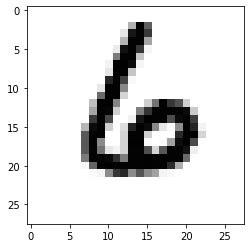

In [ ]:
# Random sample test
with torch.no_grad():
  r = random.randint(0, len(mnist_test) - 1)
  img_sample = mnist_test.data[r].view(1, 1, 28, 28).float().to(device)
  label_sample = mnist_test.targets[r].to(device)

  print('Label: ', label_sample.item())
  sample_prediction = model(img_sample)
  print('Prediction: ', torch.argmax(sample_prediction, axis=1).item())

  plt.imshow(mnist_test.data[r].view(28, 28), cmap='Greys', interpolation='nearest')
  plt.show()

### 4. Assignment

### 다음 미완성 코드를 활용해 새로운 data를 학습해보자

- Training data image
  + Shape: (?,3,64,128)
    * 여러장의, RGB, 64x128 size의 이미지라고 가정하자

- Test data image
  + Shape: (?,3,?,?)
    * 여러장의, RGB, size를 알 수 없는 이미지라고 가정하자

- Labels
  + image의 class는 2가지 이다
  + data folder의 구성을 참고하자

- Data folder 위치
  + 노트북 github의 data folder 2개를 적당한 위치에 카피해 사용한다

In [1]:
# 임포트 및 GPU사용, colab에 mount, 시드 부여 등 학습 모델 외적으로 사용하는 코드들
import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init
from torch.utils.data import DataLoader
import random
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

from google.colab import drive
drive.mount('/content/drive')

# for reproducibility
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

# train
##### 직접 dataset을 만들어 학습할 때 자주 사용되는 함수이니 기능을 숙지한다
##### pytorch 공식 홈페이지에서 관련 함수의 정보를 직접 찾아보는 것을 추천한다

# transform하는 일련의 작업들을 묶은 것이 Compose이다. 이번 코드에서는 Tensor로 transform하는 하나의 작업만 포함한다.
trans = transforms.Compose([transforms.ToTensor()])

# train_data를 Image가 담겨있는 folder 통채로 가져오는 코드이다. 폴더의 이름이 label이 되며 이번 코드에서는 구글 드라이브의 저장소를 이용하였다. 
#또한 Tensor로 이미지 파일을 자동으로 transform한다, 
train_data = dsets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/courses/AI_Appl/train_data', transform=trans)

# Dataloader를 이용하여 traindata를 Dataset으로 저장한다. batch는 8개의 사이즈를 가지며, 데이터셋은 epoch마다 셔플된다. label이 2개라서 num_workers가 2이다.
data_loader = DataLoader(dataset = train_data, batch_size = 8,shuffle = True, num_workers=2)

##### 지난 assignment에서 작성한 model을 활용한다. 바뀐 image의 size는 64x128이며, 흑백이 아닌 RGB 3개의 채널임에 유의한다.
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 Input shape=(?, 3, 64, 128)
        #    Conv     -> (?, 32, 64, 128)
        #    Pool     -> (?, 32, 32, 64)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 Input shape=(?, 32, 32, 64)
        #    Conv      ->(?, 64, 32, 64)
        #    Pool      ->(?, 64, 16, 32)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 Input shape=(?, 64, 16, 32)
        #    Conv      ->(?, 128, 16, 32)
        #    Pool      ->(?, 128, 8, 16)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L4 Linear 128x8x16 inputs -> 625 outputs
        self.layer4 = torch.nn.Sequential(
            torch.nn.Linear(128*8*16, 625, bias=True),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5))  #Dropout이란 뉴럴네트워크의 경로 몇개를 버리면서 학습하는 것으로, overfitting을 방지하는 효과를 가진다.
            torch.nn.init.xavier_uniform_(self.layer4.weight)
        # L5 Linear 625 inputs -> 2 outputs
        self.layer5 = torch.nn.Linear(625, 2, bias=True)
        # 자비에르 유니폼: Linear의 초깃값을 0이아닌 자비에르방식으로 설정.
        torch.nn.init.xavier_uniform_(self.layer5.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC , Linear연산을 하기 전에 한줄 벡터로 변환하여 입력한다.
        out = self.layer4(out)
        out = self.layer5(out)
        return out

# parameters
learning_rate = 0.0005
training_epochs = 10

# contruct model
model = CNN().to(device)

# define cost/loss & optimizer, Multinominal 알고리즘을 사용하여 CrossEntropyLoss function을 사용하였고, SGD모델과 유사한 Adam모델을 옵티마이저로 사용하였다.
criterion = torch.nn.CrossEntropyLoss().to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##### 학습이 이루어지는 loop
##### 지난 source code를 그대로 사용해도 되지만, 연습삼아 직접 작성해보자
total_batch = len(data_loader)
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0

    for num,data in enumerate(data_loader):
        X , Y = data 
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

# test
##### 직접 dataset을 만들어 학습할 때 자주 사용되는 함수이니 기능을 숙지한다
##### pytorch 공식 홈페이지에서 관련 함수의 정보를 직접 찾아보는 것을 추천한다
trans=transforms.Compose([transforms.Resize((64,128)),transforms.ToTensor()])
test_data = dsets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/courses/AI_Appl/test_data', transform=trans)
test_set = DataLoader(dataset = test_data, batch_size = len(test_data))

with torch.no_grad():
    for num,data in enumerate(data_loader):
        X , Y = data 
        X = X.to(device)
        Y = Y.to(device)

    prediction = model(X)
    correct_prediction = torch.argmax(prediction, 1) == Y
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
##### 결과 test가 이루어지는 loop
##### 지난 source code를 그대로 사용해도 되지만, 연습삼아 직접 작성해보자

IndentationError: ignored